In [ ]:
import pickle
with open("spreadsheet_boolean.pkl", "rb") as f:
    df = pickle.load(f)

In [2]:
import os
import joblib

# Function to train or load model
def safe_train(model, model_name, X_train, y_train):
    model_path = f"{model_name}.pkl"

    if os.path.exists(model_path):
        print(f"✅ {model_name} already trained! Loading instead of training...")
        return joblib.load(model_path)
    else:
        print(f"🚀 Training {model_name}...")
        model.fit(X_train, y_train)
        joblib.dump(model, model_path)
        print(f"✅ {model_name} trained & saved!")
        return model


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df.set_index('date',inplace=True)

In [6]:
df.head()

,symbol,streak_len,direction,occurrence,performance,vol,ma5_pos,ma200_pos,ma5_neg,ma200_neg,next_day_actual,bin_name
date,,,,,,,,,,,,
2025-02-27,TSLA,6,-1,19,-1,1,0,1,1,0,1,6 -1 -1 -1 1 0 1 1 0
2025-02-26,TSLA,5,-1,53,-1,1,0,1,1,0,-1,5 -1 -1 -1 1 0 1 1 0
2025-02-25,MSFT,3,-1,620,-1,-1,0,0,-1,1,1,3 -1 -1 -1 -1 0 0 -1 1
2025-02-25,TSLA,4,-1,103,-1,-1,0,1,1,0,-1,4 -1 -1 -1 -1 0 1 1 0
2025-02-24,TSLA,3,-1,230,-1,-1,0,1,-1,0,-1,3 -1 -1 -1 -1 0 1 -1 0


In [7]:
df['next_day_actual'].value_counts()

next_day_actual
 1    2742
-1    2479
 0     162
Name: count, dtype: int64

In [8]:
# removing all the 0 values (indicating no change) from next_day_actual
df = df[df['next_day_actual'] != 0]

In [9]:
df.shape

(5221, 12)

In [10]:
# now the values in the next_day_actual is 1 and -1, so we convert -1 to 0
def convert_negative_to_zero(df, column_name):
    df[column_name] = df[column_name].replace(-1, 0)
    return df
df = convert_negative_to_zero(df, 'next_day_actual')

In [11]:
df['next_day_actual'].unique()

array([1, 0])

In [12]:
df.dtypes

symbol             object
streak_len          int64
direction           int64
occurrence          int64
performance         int64
vol                 int64
ma5_pos             int64
ma200_pos           int64
ma5_neg             int64
ma200_neg           int64
next_day_actual     int64
bin_name           object
dtype: object

In [13]:
df['streak_len'] = df['streak_len'].astype(int)
df.drop(columns=['symbol','bin_name','occurrence'],inplace=True)
df.head()

,streak_len,direction,performance,vol,ma5_pos,ma200_pos,ma5_neg,ma200_neg,next_day_actual
date,,,,,,,,,
2025-02-27,6,-1,-1,1,0,1,1,0,1
2025-02-26,5,-1,-1,1,0,1,1,0,0
2025-02-25,3,-1,-1,-1,0,0,-1,1,1
2025-02-25,4,-1,-1,-1,0,1,1,0,0
2025-02-24,3,-1,-1,-1,0,1,-1,0,0


In [14]:
from sklearn.model_selection import train_test_split
x = df.iloc[:,:-1]
y = df['next_day_actual']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=42)

### One Hot Encoding all the columns

In [15]:
cols = x.columns.to_list()
cols

['streak_len',
 'direction',
 'performance',
 'vol',
 'ma5_pos',
 'ma200_pos',
 'ma5_neg',
 'ma200_neg']

In [16]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(df[cols])
encoded_cols = list(encoder.get_feature_names_out(cols)) # it retrieves the names of the new encoded features created by the OneHotEncoder and stores them in the list encoded_cols.

In [17]:
x_train[encoded_cols] = encoder.transform(x_train[cols])
x_test[encoded_cols] = encoder.transform(x_test[cols])

In [18]:
x_train.columns

Index(['streak_len', 'direction', 'performance', 'vol', 'ma5_pos', 'ma200_pos',
       'ma5_neg', 'ma200_neg', 'streak_len_3', 'streak_len_4', 'streak_len_5',
       'streak_len_6', 'streak_len_7', 'streak_len_8', 'streak_len_9',
       'streak_len_10', 'streak_len_11', 'streak_len_12', 'streak_len_13',
       'direction_-1', 'direction_0', 'direction_1', 'performance_-1',
       'performance_0', 'performance_1', 'vol_-1', 'vol_0', 'vol_1',
       'ma5_pos_-1', 'ma5_pos_0', 'ma5_pos_1', 'ma200_pos_-1', 'ma200_pos_0',
       'ma200_pos_1', 'ma5_neg_-1', 'ma5_neg_0', 'ma5_neg_1', 'ma200_neg_-1',
       'ma200_neg_0', 'ma200_neg_1'],
      dtype='object')

In [19]:
x_train = x_train[encoded_cols]
x_test = x_test[encoded_cols]

### Converting encoded columns & target column to boolean

In [20]:
# Create DataFrames with the encoded data
x_train_encoded_df = pd.DataFrame(x_train, columns=encoded_cols, index=x_train.index)
x_test_encoded_df = pd.DataFrame(x_test, columns=encoded_cols, index=x_test.index)

In [21]:
x_train = x_train_encoded_df.astype(bool)
x_test = x_test_encoded_df.astype(bool)
y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

### Training the model

In [22]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42) 

In [23]:
model = safe_train(model, "model", x_train, y_train)

✅ model already trained! Loading instead of training...


In [24]:
model.score(x_train,y_train)

0.6051245210727969

In [25]:
model.score(x_test,y_test)

0.49856459330143543

In [26]:
importance_df = pd.DataFrame({
    'Feature':x_train.columns, 
    'Importance':model.feature_importances_
}).sort_values('Importance', ascending=False)
importance_df

,Feature,Importance
17,vol_-1,0.069656
1,streak_len_4,0.068749
0,streak_len_3,0.068174
19,vol_1,0.066521
2,streak_len_5,0.064274
14,performance_-1,0.053255
3,streak_len_6,0.052222
16,performance_1,0.051588
4,streak_len_7,0.042546
25,ma200_pos_1,0.041668


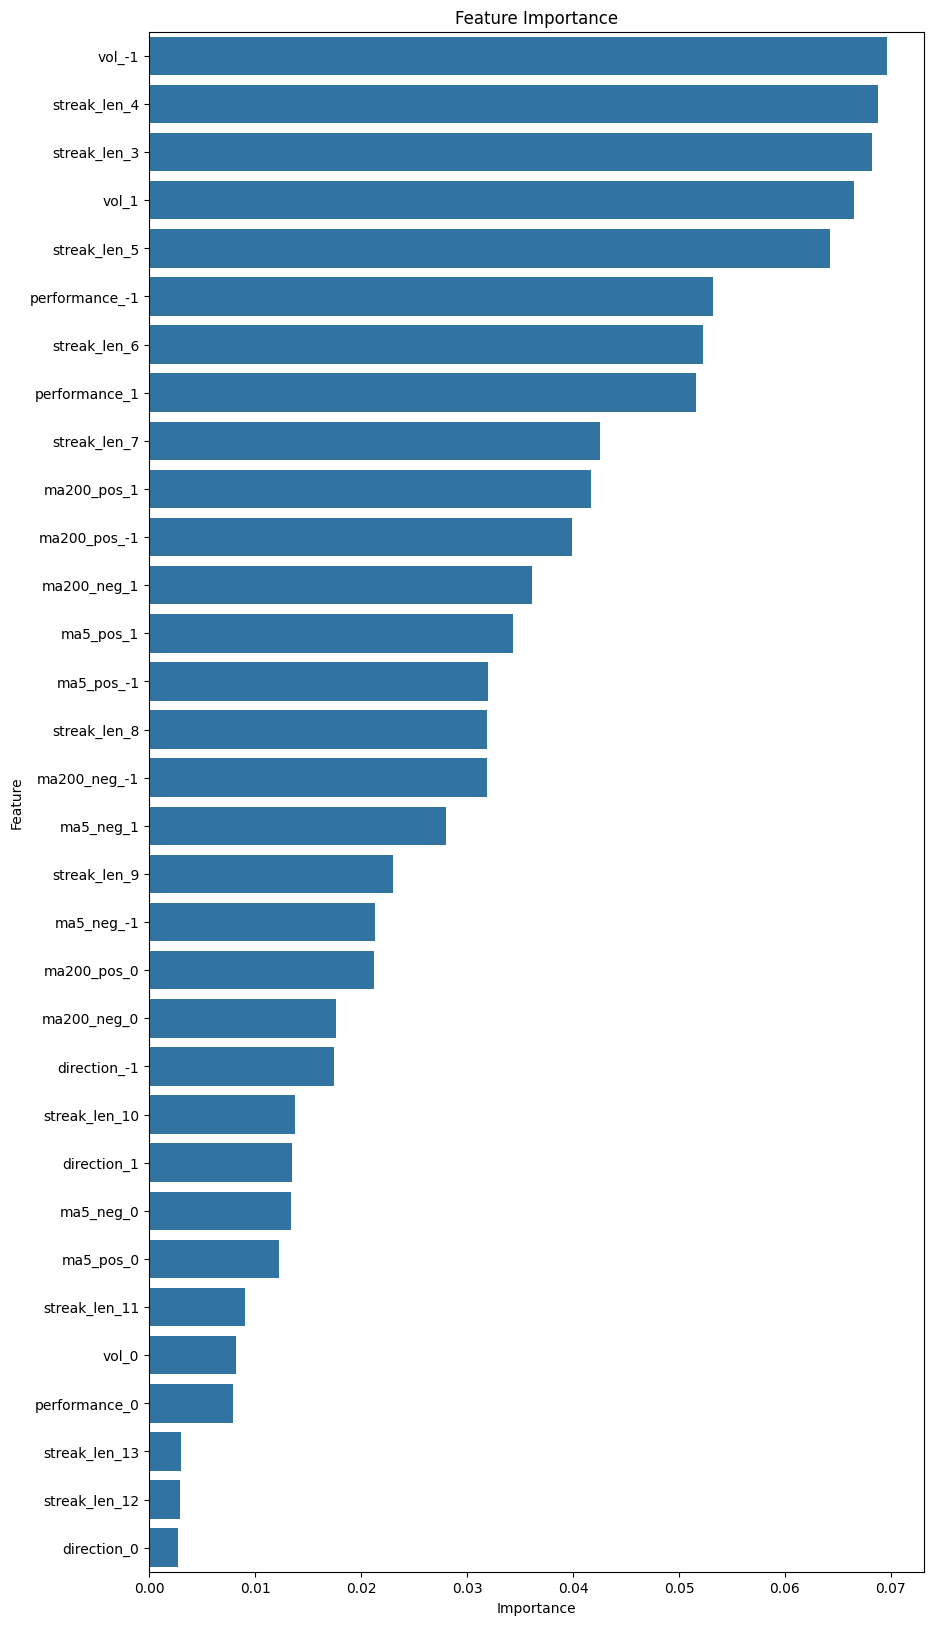

In [27]:
# Set the size of the plot
plt.figure(figsize=(10, 20))

# Create a horizontal bar plot
sns.barplot(data=importance_df, x='Importance', y='Feature')

# Set the title
plt.title('Feature Importance')

# Rotate the y-axis labels for better readability
plt.yticks(rotation=0)

# Show the plot
plt.show()

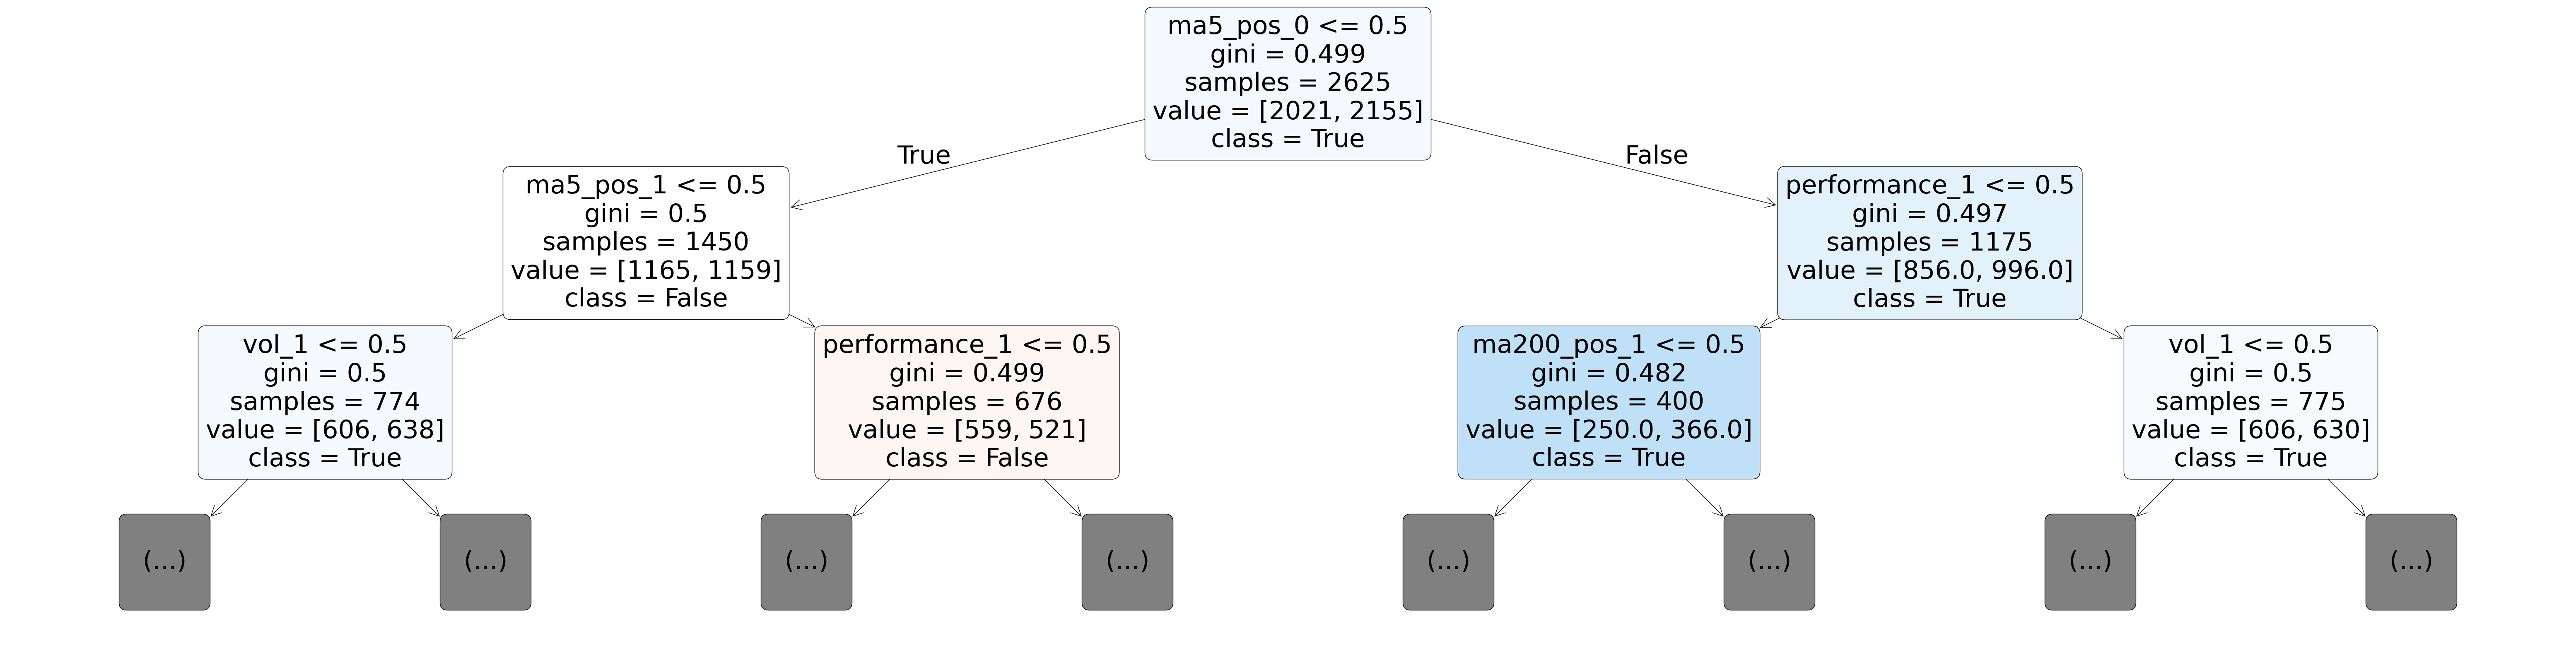

In [28]:
from sklearn.tree import plot_tree
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[0], feature_names=x_train.columns, max_depth=2, filled=True, rounded=True, class_names=[str(cls) for cls in model.classes_]);
# model.estimator[] selects from different decision trees

### Hyperparameter Tuning

In [29]:
# helper function to make it easy to test hyperparameters
def test_params(**params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(x_train, y_train)
    return model.score(x_train, y_train), model.score(x_test, y_test)

In [30]:
test_params(max_depth=5)

(0.5632183908045977, 0.5205741626794258)

In [31]:
# Error evaluation using RMSE
from sklearn.metrics import mean_squared_error

def rmse(a, b):
    return mean_squared_error(a, b) ** 0.5  # Take the square root manually
preds = model.predict(x_train)
preds
rmse(preds, y_train)

0.6283911830438131

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_train, preds))
print(preds)

              precision    recall  f1-score   support

       False       0.61      0.47      0.53      1980
        True       0.60      0.73      0.66      2196

    accuracy                           0.61      4176
   macro avg       0.61      0.60      0.60      4176
weighted avg       0.61      0.61      0.60      4176

[ True  True  True ...  True  True False]


In [33]:
test_params(max_depth=12)

(0.6048850574712644, 0.5062200956937799)

### Training seperately with seperate values of ma200_pos

In [34]:
ma200pos_pos = encoded_cols.copy()
ma200pos_pos.remove('ma200_pos_-1')
ma200pos_pos.remove('ma200_pos_0')

ma200pos_zero = encoded_cols.copy()
ma200pos_zero.remove('ma200_pos_-1')
ma200pos_zero.remove('ma200_pos_1')

ma200pos_neg = encoded_cols.copy()
ma200pos_neg.remove('ma200_pos_1')
ma200pos_neg.remove('ma200_pos_0')


In [35]:
x_train_pos= x_train[ma200pos_pos]
x_test_pos= x_test[ma200pos_pos]

x_train_zero= x_train[ma200pos_zero]
x_test_zero= x_test[ma200pos_zero]

x_train_neg= x_train[ma200pos_neg]
x_test_neg= x_test[ma200pos_neg]

In [40]:
model_pos = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42) 
model_pos = safe_train(model_pos, "model_pos", x_train, y_train)

✅ model_pos already trained! Loading instead of training...


In [41]:
print(model_pos.score(x_train_pos,y_train), model_pos.score(x_test_pos,y_test))

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- ma200_pos_-1
- ma200_pos_0


In [ ]:
model_zero = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42) 
model_zero = safe_train(model_zero, "model_zero", x_train, y_train)

In [ ]:
print(model_zero.score(x_train_zero,y_train), model_zero.score(x_test_zero,y_test))

In [ ]:
model_neg = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42) 
model_neg = safe_train(model_neg, "model_neg", x_train, y_train)

In [ ]:
print(model_neg.score(x_train_neg,y_train), model_neg.score(x_test_neg,y_test))

In [ ]:
import joblib

# Dictionary to store all trained models
models = {
    'model': model,  
    'model_pos': model_pos,  
    'model_zero': model_zero,  
    'model_neg': model_neg  
}

# Save each model separately
for name, model in models.items():
    joblib.dump(model, f'{name}.pkl')

print("✅ All models saved successfully!")
